#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션①
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.


### (2) 미션②  
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* 1) Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.
* 2) Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다.
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 target을 추가하여 EDA를 수행해 봅시다.


## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 필요하다고 판단되는 라이브러리를 추가하세요.
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import *


In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000) 

* 변수 중요도 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [ ]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용 데이터셋
    * feature.csv : feature 이름을 계층구조로 정리한 데이터  
 <br/>
    

* 세부 요구사항
    - 전체 데이터 'data01_train.csv' 를 불러와 'data' 변수에 저장합니다.
    - 센서 그룹 데이터 'feature.csv' 를 불러와 'features' 변수에 저장합니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/KT_aivle/DNN, RNN/2024.03.27_미니프로젝트 3차_실습자료/data01_train.csv')
feature = pd.read_csv('/content/drive/MyDrive/KT_aivle/DNN, RNN/2024.03.27_미니프로젝트 3차_실습자료/features.csv')

In [ ]:
data.isna().sum().sum()

0

## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [ ]:
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",tGravityAcc-mean()-X,tGravityAcc-mean()-Y,tGravityAcc-mean()-Z,tGravityAcc-std()-X,tGravityAcc-std()-Y,tGravityAcc-std()-Z,tGravityAcc-mad()-X,tGravityAcc-mad()-Y,tGravityAcc-mad()-Z,tGravityAcc-max()-X,tGravityAcc-max()-Y,tGravityAcc-max()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-min()-Z,tGravityAcc-sma(),tGravityAcc-energy()-X,tGravityAcc-energy()-Y,tGravityAcc-energy()-Z,tGravityAcc-iqr()-X,tGravityAcc-iqr()-Y,tGravityAcc-iqr()-Z,tGravityAcc-entropy()-X,tGravityAcc-entropy()-Y,tGravityAcc-entropy()-Z,"tGravityAcc-arCoeff()-X,1","tGravityAcc-arCoeff()-X,2","tGravityAcc-arCoeff()-X,3","tGravityAcc-arCoeff()-X,4","tGravityAcc-arCoeff()-Y,1","tGravityAcc-arCoeff()-Y,2","tGravityAcc-arCoeff()-Y,3","tGravityAcc-arCoeff()-Y,4","tGravityAcc-arCoeff()-Z,1","tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4","tGravityAcc-correlation()-X,Y","tGravityAcc-correlation()-X,Z","tGravityAcc-correlation()-Y,Z",tBodyAccJerk-mean()-X,tBodyAccJerk-mean()-Y,tBodyAccJerk-mean()-Z,tBodyAccJerk-std()-X,tBodyAccJerk-std()-Y,tBodyAccJerk-std()-Z,tBodyAccJerk-mad()-X,tBodyAccJerk-mad()-Y,tBodyAccJerk-mad()-Z,tBodyAccJerk-max()-X,tBodyAccJerk-max()-Y,tBodyAccJerk-max()-Z,tBodyAccJerk-min()-X,tBodyAccJerk-min()-Y,tBodyAccJerk-min()-Z,tBodyAccJerk-sma(),tBodyAccJerk-energy()-X,tBodyAccJerk-energy()-Y,tBodyAccJerk-energy()-Z,tBodyAccJerk-iqr()-X,tBodyAccJerk-iqr()-Y,tBodyAccJerk-iqr()-Z,tBodyAccJerk-entropy()-X,tBodyAccJerk-entropy()-Y,tBodyAccJerk-entropy()-Z,"tBodyAccJerk-arCoeff()-X,1","tBodyAccJerk-arCoeff()-X,2","tBodyAccJerk-arCoeff()-X,3","tBodyAccJerk-arCoeff()-X,4","tBodyAccJerk-arCoeff()-Y,1","tBodyAccJerk-arCoeff()-Y,2","tBodyAccJerk-arCoeff()-Y,3","tBodyAccJerk-arCoeff()-Y,4","tBodyAccJerk-arCoeff()-Z,1","tBodyAccJerk-arCoeff()-Z,2","tBodyAccJerk-arCoeff()-Z,3","tBodyAccJerk-arCoeff()-Z,4","tBodyAccJerk-correlation()-X,Y","tBodyAccJerk-correlation()-X,Z","tBodyAccJerk-correlation()-Y,Z",tBodyGyro-mean()-X,tBodyGyro-mean()-Y,tBodyGyro-mean()-Z,tBodyGyro-std()-X,tBodyGyro-std()-Y,tBodyGyro-std()-Z,tBodyGyro-mad()-X,tBodyGyro-mad()-Y,tBodyGyro-mad()-Z,tBodyGyro-max()-X,tBodyGyro-max()-Y,tBodyGyro-max()-Z,tBodyGyro-min()-X,tBodyGyro-min()-Y,tBodyGyro-min()-Z,tBodyGyro-sma(),tBodyGyro-energy()-X,tBodyGyro-energy()-Y,tBodyGyro-energy()-Z,tBodyGyro-iqr()-X,tBodyGyro-iqr()-Y,tBodyGyro-iqr()-Z,tBodyGyro-entropy()-X,tBodyGyro-entropy()-Y,tBodyGyro-entropy()-Z,"tBodyGyro-arCoeff()-X,1","tBodyGyro-arCoeff()-X,2","tBodyGyro-arCoeff()-X,3","tBodyGyro-arCoeff()-X,4","tBodyGyro-arCoeff()-Y,1","tBodyGyro-arCoeff()-Y,2","tBodyGyro-arCoeff()-Y,3","tBodyGyro-arCoeff()-Y,4","tBodyGyro-arCoeff()-Z,1","tBodyGyro-arCoeff()-Z,2","tBodyGyro-arCoeff()-Z,3","tBodyGyro-arCoeff()-Z,4","tBodyGyro-correlation()-X,Y","tBodyGyro-correlation()-X,Z","tBodyGyro-correlation()-Y,Z",tBodyGyroJerk-mean()-X,tBodyGyroJerk-mean()-Y,tBodyGyroJerk-mean()-Z,tBodyGyroJerk-std()-X,tBodyGyroJerk-std()-Y,tBodyGyroJerk-std()-Z,tBodyGyroJerk-mad()-X,tBodyGyroJerk-mad()-Y,tBodyGyroJerk-mad()-Z,tBodyGyroJerk-max()-X,tBodyGyroJerk-max()-Y,tBodyGyroJerk-max()-Z,tBodyGyroJerk-min()-X,tBodyGyroJerk-min()-Y,tBodyGyroJerk-min()-Z,tBodyGyroJ

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
tBodyAcc-mean()-X,5881.0,0.274811,0.067614,-0.503823,0.262919,0.277154,0.288526,1.000000
tBodyAcc-mean()-Y,5881.0,-0.017799,0.039422,-0.684893,-0.024877,-0.017221,-0.010920,1.000000
tBodyAcc-mean()-Z,5881.0,-0.109396,0.058373,-1.000000,-0.121051,-0.108781,-0.098163,1.000000
tBodyAcc-std()-X,5881.0,-0.603138,0.448807,-1.000000,-0.992774,-0.943933,-0.242130,1.000000
tBodyAcc-std()-Y,5881.0,-0.509815,0.501815,-0.999844,-0.977680,-0.844575,-0.034499,0.916238
...,...,...,...,...,...,...,...,...
"angle(tBodyGyroJerkMean,gravityMean)",5881.0,-0.007099,0.476738,-1.000000,-0.373345,-0.000847,0.356236,0.996078
"angle(X,gravityMean)",5881.0,-0.491501,0.509069,-1.000000,-0.811397,-0.709441,-0.511330,0.977344
"angle(Y,gravityMean)",5881.0,0.059299,0.297340,-1.000000,-0.018203,0.182893,0.248435,0.478157
"angle(Z,gravityMean)",5881.0,-0.054594,0.278479,-0.980143,-0.141555,0.003951,0.111932,1.000000


In [ ]:
feature.head()

,sensor,agg,axis,feature_name
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z
3,tBodyAcc,std(),X,tBodyAcc-std()-X
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y


### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

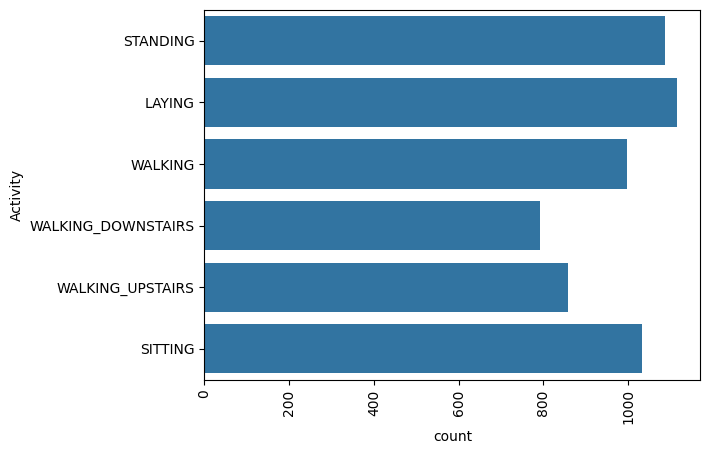

In [ ]:
sns.countplot(data['Activity'])
plt.xticks(rotation=90)
plt.show()

In [ ]:
feature.head()

,sensor,agg,axis,feature_name
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z
3,tBodyAcc,std(),X,tBodyAcc-std()-X
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y


### (3) 센서 그룹 데이터: features

* **세부 요구사항**
    - feature 이름에 대한 계층 구조별로 변수의 수를 카운트 해 봅시다.
        - sensor 별 변수의 개수
        - agg(regation) 별 변수의 개수
        - axis 별 변수의 개수

In [ ]:
feature.groupby(['sensor']).count()

,agg,axis,feature_name
sensor,,,
angle,7,7,7
fBodyAcc,79,78,79
fBodyAccJerk,79,78,79
fBodyAccMag,13,0,13
fBodyBodyAccJerkMag,13,0,13
fBodyBodyGyroJerkMag,13,0,13
fBodyBodyGyroMag,13,0,13
fBodyGyro,79,78,79
tBodyAcc,40,39,40


In [ ]:
feature.groupby(['agg']).count()


,sensor,axis,feature_name
agg,,,
X,1,1,1
Y,1,1,1
Z,1,1,1
arCoeff(),60,60,60
arCoeff()1,5,0,5
arCoeff()2,5,0,5
arCoeff()3,5,0,5
arCoeff()4,5,0,5
bandsEnergy(),126,126,126


In [ ]:
feature.groupby(['axis']).count()


,sensor,agg,feature_name
axis,,,
"1,16",5,5,5
"1,16.1",2,2,2
"1,16.2",2,2,2
"1,24",5,5,5
"1,24.1",2,2,2
"1,24.2",2,2,2
"1,8",5,5,5
"1,8.1",2,2,2
"1,8.2",2,2,2


## 3.데이터 분석 : 미션1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

In [68]:
target = 'Activity'
x = data.drop(target, axis=1)
y = data[target]
x.shape, y.shape

((5881, 569), (5881,))

In [73]:
x_train, x_val, y_train, y_val = train_test_split(x, y, stratify=y, test_size=.3)

x_train.shape, x_val.shape, y_train.shape, y_val.shape

((4116, 569), (1765, 569), (4116,), (1765,))

### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

In [74]:
model = RandomForestClassifier(random_state=1)
model.fit(x_train, y_train)
pred = model.predict(x_val)

In [76]:
accuracy_score(y_val,pred)

0.9994334277620397

In [75]:
print(classification_report(y_val, pred))

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       335
           SITTING       1.00      1.00      1.00       310
          STANDING       1.00      1.00      1.00       326
           WALKING       1.00      1.00      1.00       300
WALKING_DOWNSTAIRS       1.00      1.00      1.00       237
  WALKING_UPSTAIRS       1.00      1.00      1.00       257

          accuracy                           1.00      1765
         macro avg       1.00      1.00      1.00      1765
      weighted avg       1.00      1.00      1.00      1765



In [ ]:
model.feature_importances_,

(562,)

In [ ]:
ser.sort_values(ascending=False)

tGravityAcc-min()-X               0.040950
tGravityAcc-energy()-X            0.032194
tGravityAcc-min()-Y               0.028935
tGravityAcc-max()-Y               0.028053
tGravityAcc-mean()-X              0.026167
                                    ...   
fBodyAcc-bandsEnergy()-17,24      0.000087
tBodyAcc-mean()-Z                 0.000086
fBodyBodyGyroMag-min()            0.000080
fBodyAcc-bandsEnergy()-33,48.1    0.000066
fBodyBodyGyroJerkMag-sma()        0.000064
Length: 562, dtype: float64

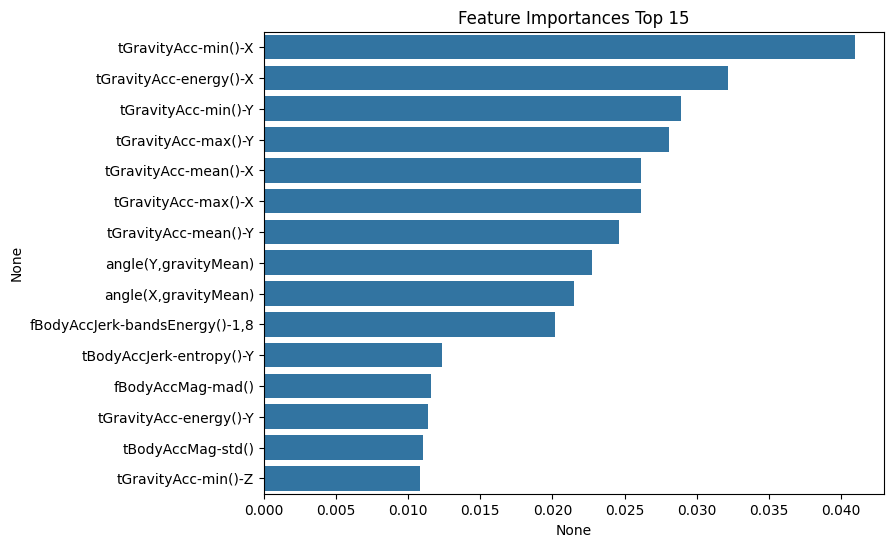

In [ ]:
ser = pd.Series(model.feature_importances_, index=list(x_train))
top15 = ser.sort_values(ascending=False)[:15]
plt.figure(figsize=(8,6))
plt.title('Feature Importances Top 15')
sns.barplot(x=top15, y=top15.index)
plt.show()

In [ ]:
plot_feature_importance(model.feature_importances_,list(x_train),topn=15)

### (3) feature 그룹별 분석

* **세부 요구사항**
    - 제공된 features.csv 에는 feature에 대한 계층구조를 정리해 놓았습니다.
    - features와 변수중요도 결과를 merge 하시오.
    - sensor 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석을 수행 하시오.
    - sensor + agg 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석을 수행 하시오.


In [ ]:
importance['feature_name'] = list(x_train)

In [ ]:
importance = pd.DataFrame(model.feature_importances_, columns=['importance1'])
# pd.merge(importance,feature,how='left',on)
importance['feature_name'] = list(x_train)

In [ ]:
feature1 = pd.merge(feature, importance,on='feature_name')

In [ ]:
feature1

,sensor,agg,axis,feature_name,importance1
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000140
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000214
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000256
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.008993
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000285
...,...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000432
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000716
558,angle,X,gravityMean,"angle(X,gravityMean)",0.023124
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.024705


In [ ]:
feature1.groupby('sensor')[['importance1']].sum().sort_values(by='importance1')

,importance1
sensor,
fBodyBodyGyroMag,0.003336
tBodyGyroMag,0.003787
fBodyBodyGyroJerkMag,0.005072
tBodyGyroJerkMag,0.005960
fBodyBodyAccJerkMag,0.008945
tGravityAccMag,0.028352
tBodyAccJerkMag,0.028516
tBodyAccMag,0.029073
tBodyGyroJerk,0.032879


In [ ]:
feature1.groupby(['sensor','agg'])[['importance1']].sum().sort_values(by='importance1', ascending=False)


importance1
sensor               agg                           
tGravityAcc          min()                 0.080721
                     arCoeff()             0.070298
fBodyAccJerk         bandsEnergy()         0.062696
tGravityAcc          max()                 0.059441
                     mean()                0.058024
                     energy()              0.049609
fBodyGyro            bandsEnergy()         0.038981
fBodyAcc             bandsEnergy()         0.026814
angle                Y                     0.022711
                     X                     0.021467
tBodyAccJerk         mad()                 0.018881
                     entropy()             0.017407
                     iqr()                 0.012877
tBodyAcc             correlation()         0.012783
fBodyAccJerk         entropy()             0.012737
fBodyAccMag          mad()                 0.011587
fBodyGyro            maxInds               0.011431
tBodyAccMag          std()                 0.011020
tGravityAcc          entropy()             0.010917
fBodyAccMag          energy()              0.010731
tBodyAccJerk         std()                 0.010385
                     energy()              0.009659
fBodyAcc             mad()                 0.008875
fBodyAccJerk         mad()                 0.008755
angle                Z                     0.008659
tGravityAccMag       std()                 0.008632
tBodyGyroJerk        iqr()                 0.008462
tBodyAccJerkMag      energy()              0.008289
fBodyAccMag          std()                 0.008037
tBodyGyro            iqr()                 0.007757
fBodyAccJerk         std()                 0.007410
tBodyAccJerk         sma()                 0.006543
fBodyAcc             energy()              0.006483
tBodyAcc             std()                 0.006445
tBodyAccJerkMag      sma()                 0.006443
                     entropy()             0.006184
tGravityAccMag       mad()                 0.006051
tBodyAcc             max()                 0.005970
fBodyAccJerk         maxInds               0.005742
tGravityAcc          correlation()         0.005496
tBodyAcc             energy()              0.005404
fBodyGyro            mad()                 0.005154
tBodyGyroJerk        arCoeff()             0.004889
fBodyAccJerk         mean()                0.004855
tBodyAccMag          arCoeff()1            0.004775
fBodyAccJerk         energy()              0.004756
tBodyGyro            mad()                 0.004585
fBodyAcc             entropy()             0.004501
tGravityAccMag       arCoeff()1            0.004500
tBodyGyro            arCoeff()             0.004325
tBodyAccMag          mad()                 0.004293
tBodyGyro            correlation()         0.004050
tBodyGyroJerk        mad()                 0.004015
fBodyAccMag          sma()                 0.004001
tBodyAcc             iqr()                 0.003827
tGravityAcc          sma()                 0.003784
tBodyAcc             arCoeff()             0.003716
tBodyGyro            max()                 0.003571
tGravityAcc          std()                 0.003514
fBodyAcc             max()                 0.003400
tGravityAcc          mad()                 0.003370
fBodyGyro            meanFreq()            0.003347
fBodyAcc             skewness()            0.003300
tBodyGyroJerk        energy()              0.003206
fBodyAcc             meanFreq()            0.003204
fBodyGyro            mean()                0.003201
                     std()                 0.003051
fBodyAccJerk         max()                 0.002992
fBodyGyro            energy()              0.002952
                     max()                 0.002796
tBodyAccJerk         max()                 0.002655
                     arCoeff()             0.002652
tBodyAccMag          max()                 0.002636
tBodyGyroJerkMag     mean()                0.002539
fBodyAccMag          entropy()             0.002526
tBodyAccJerkMag      mean()         

## 4.데이터 분석 : 미션2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* 1) Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.
* 2) Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다.
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 target을 추가하여 EDA를 수행해 봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_dynamic 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_dynamic 추가

In [ ]:
data['is_dynamic'] = np.where((data['Activity'] == 'STANDING') | (data.Activity == 'SITTING') | (data.Activity == 'LAYING'), 0, 1)
data['is_dynamic'].value_counts()


is_dynamic
0    3234
1    2647
Name: count, dtype: int64

#### 2) 기본모델 생성

In [ ]:
x = data.drop([target,'is_dynamic'], axis=1)
y = data['is_dynamic']
x.shape, y.shape


((5881, 562), (5881,))

In [ ]:
x_trian, x_val, y_train, y_val = train_test_split(x, y, stratify=y, test_size=.2)
x_trian.shape, x_val.shape, y_train.shape, y_val.shape

((4704, 562), (1177, 562), (4704,), (1177,))

In [ ]:
model2 = RandomForestClassifier(random_state=1234)
model2.fit(x_trian, y_train)
pred2 = model2.predict(x_val)


In [ ]:
print(classification_report(y_val, pred2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       647
           1       1.00      1.00      1.00       530

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



In [ ]:
y_train.dtype

dtype('int64')

#### 3) 변수중요도 상위 5개 분석

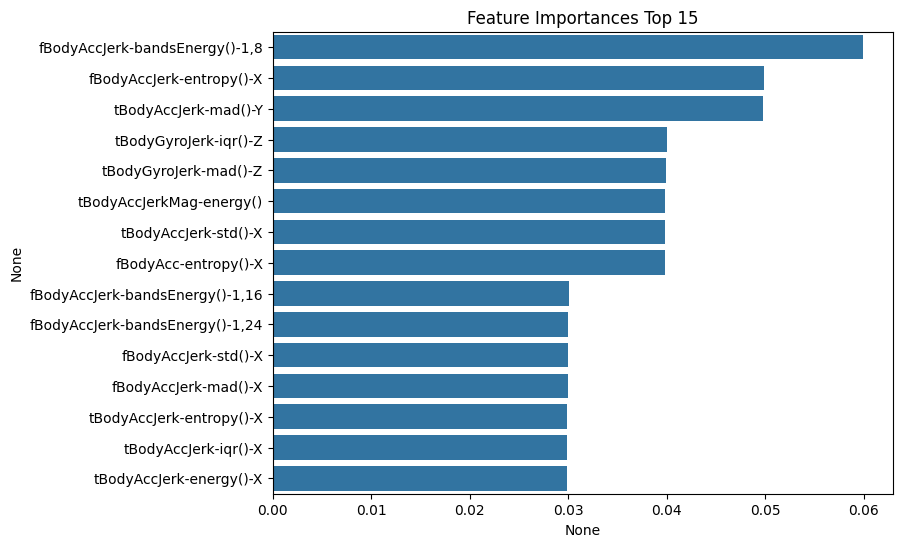

In [ ]:
ser = pd.Series(model2.feature_importances_, index=list(x_train))
top15 = ser.sort_values(ascending=False)[:15]
plt.figure(figsize=(8,6))
plt.title('Feature Importances Top 15')
sns.barplot(x=top15, y=top15.index)
plt.show()

In [ ]:
plot_feature_importance(model2.feature_importances_, list(x_train), topn=15)

#### 4) feature 그룹별 분석

In [ ]:
importance2 = pd.DataFrame(model2.feature_importances_, columns=['importance2'])
# pd.merge(importance,feature,how='left',on)
importance2['feature_name'] = list(x_train)

In [ ]:
feature2 = pd.merge(feature, importance2,on='feature_name')

In [ ]:
feature2

,sensor,agg,axis,feature_name,importance2
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000034
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000000
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000009
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.000004
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000000
...,...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000000
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000000
558,angle,X,gravityMean,"angle(X,gravityMean)",0.000051
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.000154


In [ ]:
feature2.groupby('sensor')[['importance2']].sum().sort_values(by='importance2')

,importance2
sensor,
fBodyBodyGyroMag,0.000000
tBodyGyroMag,0.000009
tBodyAccMag,0.000059
fBodyBodyGyroJerkMag,0.000075
fBodyAccMag,0.000131
tGravityAccMag,0.000136
angle,0.000240
tGravityAcc,0.000983
tBodyGyroJerkMag,0.009939


In [ ]:
feature2.groupby(['sensor','agg'])[['importance2']].sum().sort_values(by='importance2')


importance2
sensor               agg                           
fBodyGyro            entropy()             0.000000
tBodyGyroMag         std()                 0.000000
tBodyAcc             min()                 0.000000
tGravityAccMag       sma()                 0.000000
tBodyGyroMag         min()                 0.000000
                     mean()                0.000000
                     max()                 0.000000
tBodyAccJerk         max()                 0.000000
                     mean()                0.000000
                     min()                 0.000000
tBodyGyroMag         mad()                 0.000000
                     iqr()                 0.000000
tBodyAccJerkMag      arCoeff()1            0.000000
                     arCoeff()2            0.000000
                     arCoeff()3            0.000000
                     arCoeff()4            0.000000
tBodyAcc             iqr()                 0.000000
                     entropy()             0.000000
                     energy()              0.000000
tGravityAcc          correlation()         0.000000
fBodyBodyGyroMag     max()                 0.000000
                     maxInds               0.000000
                     mean()                0.000000
                     meanFreq()            0.000000
                     min()                 0.000000
                     skewness()            0.000000
                     sma()                 0.000000
tBodyGyroMag         entropy()             0.000000
fBodyBodyGyroMag     std()                 0.000000
tBodyGyroJerkMag     iqr()                 0.000000
fBodyGyro            iqr()                 0.000000
                     kurtosis()            0.000000
                     maxInds               0.000000
                     mean()                0.000000
                     min()                 0.000000
                     skewness()            0.000000
tGravityAcc          sma()                 0.000000
fBodyBodyGyroMag     mad()                 0.000000
tBodyGyroMag         energy()              0.000000
tBodyAccJerkMag      max()                 0.000000
tBodyGyro            sma()                 0.000000
                     std()                 0.000000
tBodyGyroJerk        arCoeff()             0.000000
                     correlation()         0.000000
tBodyGyroJerkMag     std()                 0.000000
                     min()                 0.000000
tBodyGyroJerk        max()                 0.000000
tBodyGyroJerkMag     max()                 0.000000
tBodyGyroJerk        std()                 0.000000
tBodyGyroJerkMag     arCoeff()1            0.000000
                     arCoeff()2            0.000000
                     arCoeff()3            0.000000
                     arCoeff()4            0.000000
                     energy()              0.000000
                     entropy()             0.000000
tBodyGyro            mean()                0.000000
                     max()                 0.000000
tBodyGyroMag         arCoeff()1            0.000000
                     arCoeff()2            0.000000
                     arCoeff()4            0.000000
tBodyAccJerkMag      min()                 0.000000
tBodyGyroMag         arCoeff()3            0.000000
tBodyAccJerkMag      std()                 0.000000
tBodyAccMag          arCoeff()1            0.000000
                     arCoeff()2            0.000000
                     arCoeff()3            0.000000
tBodyAccJerkMag      mad()                 0.000000
tBodyAccMag          arCoeff()4            0.000000
                     iqr()                 0.000000
                     mad()                 0.000000
                     mean()                0.000000
                     min()                 0.000000
                     std()                 0.000000
tBodyGyro            correlation()         0.000000
                     energy()              0.000000
tBodyAccMag          entropy()      

### (2) 개별 동작 분석 : is_standing


* **세부 요구사항**
    - Target인 Activity를 is_standing 변수로 변경하시오.
        * 값 1 : STANDING
        * 값 0 : 나머지
    - is_standing 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_standing 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_standing 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_standing 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [ ]:

data['is_standing'] = np.where(data.Activity == 'STANDING', 1, 0)
data['is_standing'].value_counts()


is_standing
0    4794
1    1087
Name: count, dtype: int64

In [ ]:
x = data.drop([target,'is_dynamic', 'is_standing'], axis=1)
y = data['is_standing']
x.shape, y.shape


((5881, 562), (5881,))

In [ ]:
x_trian, x_val, y_train, y_val = train_test_split(x, y, stratify=y, test_size=.2)
x_trian.shape, x_val.shape, y_train.shape, y_val.shape

((4704, 562), (1177, 562), (4704,), (1177,))

In [ ]:
model3 = RandomForestClassifier(random_state=1234)
model3.fit(x_trian, y_train)
pred3 = model3.predict(x_val)

In [ ]:
print(classification_report(y_val, pred3))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       959
           1       0.96      0.94      0.95       218

    accuracy                           0.98      1177
   macro avg       0.97      0.97      0.97      1177
weighted avg       0.98      0.98      0.98      1177



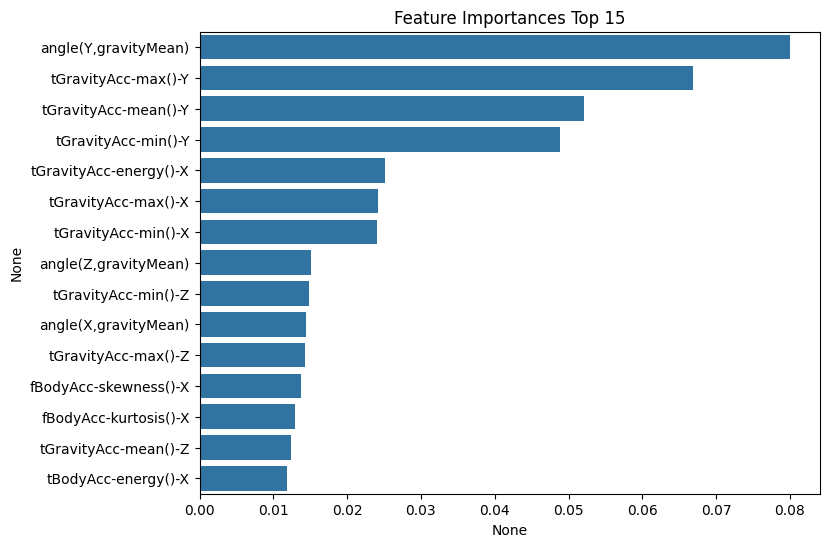

In [ ]:
ser = pd.Series(model3.feature_importances_, index=list(x_train))
top15 = ser.sort_values(ascending=False)[:15]
plt.figure(figsize=(8,6))
plt.title('Feature Importances Top 15')
sns.barplot(x=top15, y=top15.index)
plt.show()

In [ ]:
importance3 = pd.DataFrame(model3.feature_importances_, columns=['importance3'])
# pd.merge(importance,feature,how='left',on)
importance3['feature_name'] = list(x_train)

In [ ]:
feature3 = pd.merge(feature, importance3,on='feature_name')

In [ ]:
feature3.groupby('sensor')[['importance3']].sum().sort_values(by='importance3')

In [ ]:
feature3.groupby(['sensor','agg'])[['importance3']].sum().sort_values(by='importance3')


### (3) 개별 동작 분석 : is_sitting


* **세부 요구사항**
    - Target인 Activity를 is_sitting 변수로 변경하시오.
        * 값 1 : SITTING
        * 값 0 : 나머지
    - is_sitting 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_sitting 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_sitting 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_sitting 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [ ]:
data['is_sitting'] = np.where(data.Activity == 'SITTING', 1, 0)
data['is_sitting'].value_counts()

x = data.drop([target,'is_dynamic', 'is_standing','is_sitting'], axis=1)
y = data['is_sitting']

x_trian, x_val, y_train, y_val = train_test_split(x, y, stratify=y, test_size=.2)
x_trian.shape, x_val.shape, y_train.shape, y_val.shape

model4 = RandomForestClassifier(random_state=1234)
model4.fit(x_trian, y_train)
pred4 = model4.predict(x_val)


In [ ]:
print(classification_report(y_val, pred4))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       970
           1       0.96      0.94      0.95       207

    accuracy                           0.98      1177
   macro avg       0.97      0.97      0.97      1177
weighted avg       0.98      0.98      0.98      1177



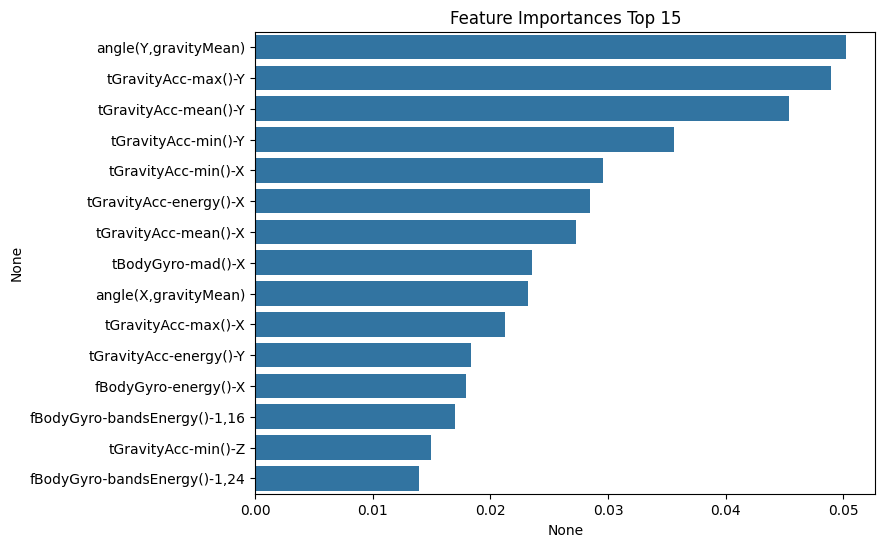

In [ ]:
ser = pd.Series(model4.feature_importances_, index=list(x_train))
top15 = ser.sort_values(ascending=False)[:15]
plt.figure(figsize=(8,6))
plt.title('Feature Importances Top 15')
sns.barplot(x=top15, y=top15.index)
plt.show()

In [ ]:
importance4 = pd.DataFrame(model4.feature_importances_, columns=['importance4'])
# pd.merge(importance,feature,how='left',on)
importance4['feature_name'] = list(x_train)

In [ ]:
feature4 = pd.merge(feature, importance4,on='feature_name')

In [ ]:
feature4.groupby('sensor')[['importance4']].sum().sort_values(by='importance4')

In [ ]:
feature4.groupby(['sensor','agg'])[['importance4']].sum().sort_values(by='importance4')

### (4) 개별 동작 분석 : is_laying


* **세부 요구사항**
    - Target인 Activity를 is_laying 변수로 변경하시오.
        * 값 1 : LAYING
        * 값 0 : 나머지
    - is_laying 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_laying 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_laying 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_laying 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [ ]:
data['is_laying'] = np.where(data.Activity == 'LAYING', 1, 0)
data['is_laying'].value_counts()

x = data.drop([target,'is_dynamic', 'is_standing','is_sitting','is_laying'], axis=1)
y = data['is_laying']

x_trian, x_val, y_train, y_val = train_test_split(x, y, stratify=y, test_size=.2)
x_trian.shape, x_val.shape, y_train.shape, y_val.shape

model5 = RandomForestClassifier(random_state=1234)
model5.fit(x_trian, y_train)
pred5 = model5.predict(x_val)


In [ ]:
print(classification_report(y_val, pred5))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       223
           1       1.00      1.00      1.00       954

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



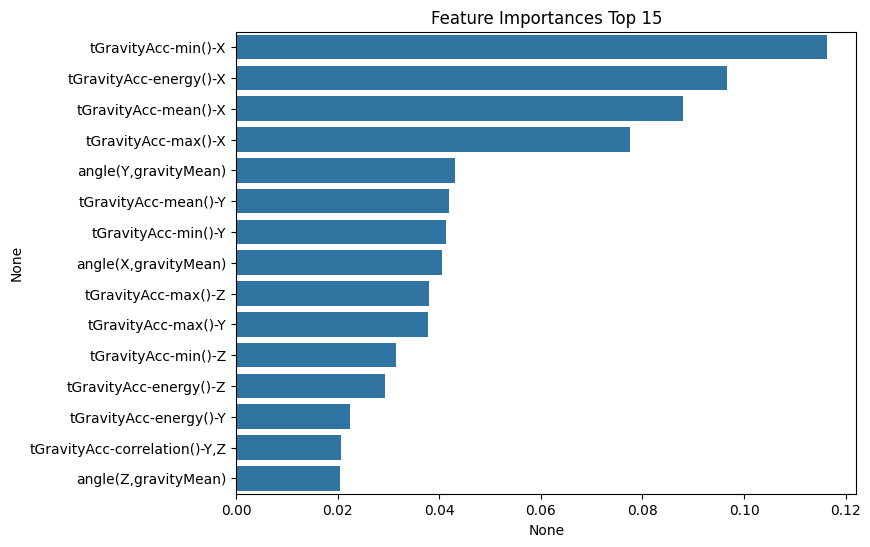

In [ ]:
ser = pd.Series(model5.feature_importances_, index=list(x_train))
top15 = ser.sort_values(ascending=False)[:15]
plt.figure(figsize=(8,6))
plt.title('Feature Importances Top 15')
sns.barplot(x=top15, y=top15.index)
plt.show()

In [ ]:
importance5 = pd.DataFrame(model5.feature_importances_, columns=['importance5'])
# pd.merge(importance,feature,how='left',on)
importance5['feature_name'] = list(x_train)

In [ ]:
feature5 = pd.merge(feature, importance5,on='feature_name')

In [ ]:
feature5.groupby('sensor')[['importance5']].sum().sort_values(by='importance5')

In [ ]:
feature5.groupby(['sensor','agg'])[['importance5']].sum().sort_values(by='importance5')

### (5) 개별 동작 분석 : is_walking


* **세부 요구사항**
    - Target인 Activity를 is_walking 변수로 변경하시오.
        * 값 1 : WALKING
        * 값 0 : 나머지
    - is_walking 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       977
           1       1.00      0.94      0.97       200

    accuracy                           0.99      1177
   macro avg       0.99      0.97      0.98      1177
weighted avg       0.99      0.99      0.99      1177



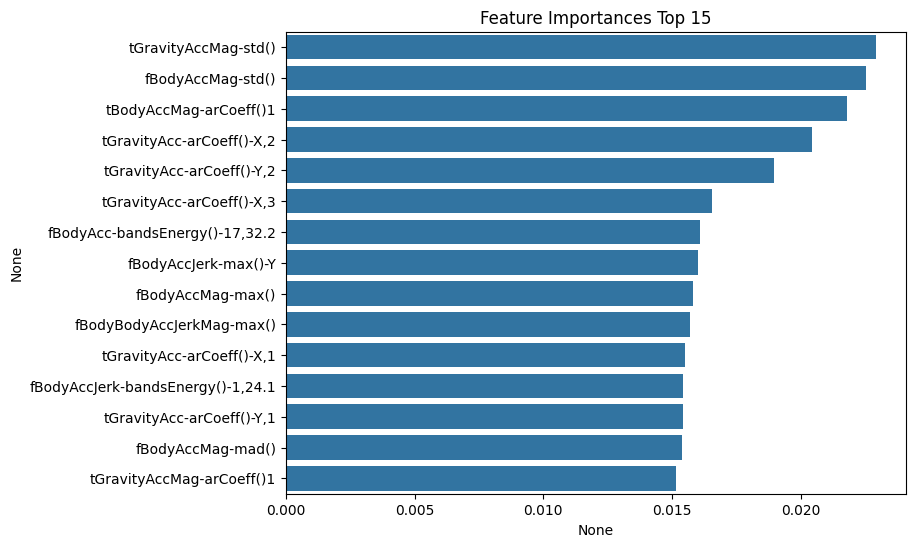

In [ ]:
data['is_walking'] = np.where(data.Activity == 'WALKING', 1, 0)
data['is_walking'].value_counts()

x = data.drop([target,'is_dynamic', 'is_standing','is_sitting','is_laying','is_walking'], axis=1)
y = data['is_walking']

x_trian, x_val, y_train, y_val = train_test_split(x, y, stratify=y, test_size=.2)
x_trian.shape, x_val.shape, y_train.shape, y_val.shape

model6 = RandomForestClassifier(random_state=1234)
model6.fit(x_trian, y_train)
pred6 = model6.predict(x_val)

print(classification_report(y_val, pred6))

ser = pd.Series(model6.feature_importances_, index=list(x_train))
top15 = ser.sort_values(ascending=False)[:15]
plt.figure(figsize=(8,6))
plt.title('Feature Importances Top 15')
sns.barplot(x=top15, y=top15.index)
plt.show()

importance6 = pd.DataFrame(model6.feature_importances_, columns=['importance6'])
# pd.merge(importance,feature,how='left',on)
importance6['feature_name'] = list(x_train)

feature6 = pd.merge(feature, importance6,on='feature_name')

In [ ]:
feature6.groupby('sensor')[['importance6']].sum().sort_values(by='importance6')

In [ ]:
feature6.groupby(['sensor','agg'])[['importance6']].sum().sort_values(by='importance6')

### (6) 개별 동작 분석 : is_walking_up


* **세부 요구사항**
    - Target인 Activity를 is_walking_up 변수로 변경하시오.
        * 값 1 : WALKING_UPSTAIRS
        * 값 0 : 나머지
    - is_walking_up 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking_up 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking_up 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking_up 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1005
           1       0.99      0.99      0.99       172

    accuracy                           1.00      1177
   macro avg       0.99      1.00      0.99      1177
weighted avg       1.00      1.00      1.00      1177



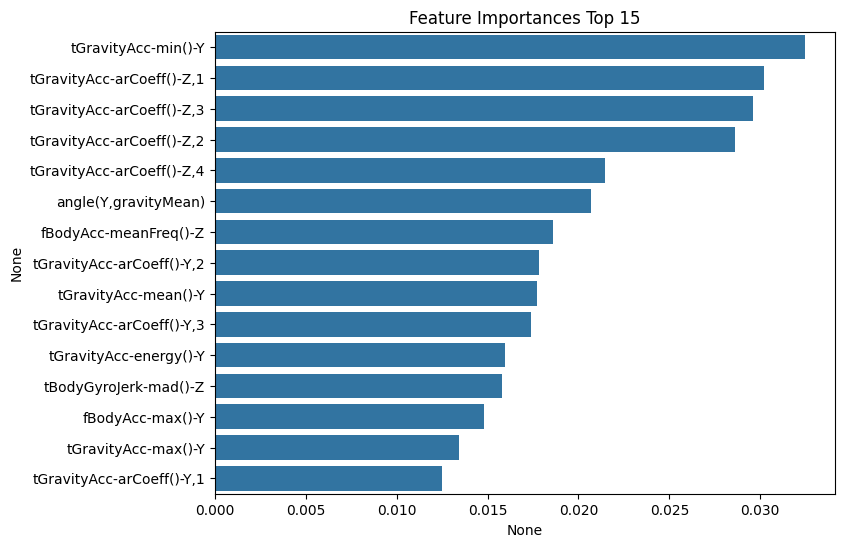

In [ ]:
data['is_walking_up'] = np.where(data.Activity == 'WALKING_UPSTAIRS', 1, 0)
data['is_walking_up'].value_counts()

x = data.drop([target,'is_dynamic', 'is_standing','is_sitting','is_laying','is_walking','is_walking_up'], axis=1)
y = data['is_walking_up']

x_trian, x_val, y_train, y_val = train_test_split(x, y, stratify=y, test_size=.2)
x_trian.shape, x_val.shape, y_train.shape, y_val.shape

model7 = RandomForestClassifier(random_state=1234)
model7.fit(x_trian, y_train)
pred7 = model7.predict(x_val)

print(classification_report(y_val, pred7))

ser = pd.Series(model7.feature_importances_, index=list(x_train))
top15 = ser.sort_values(ascending=False)[:15]
plt.figure(figsize=(8,6))
plt.title('Feature Importances Top 15')
sns.barplot(x=top15, y=top15.index)
plt.show()

importance7 = pd.DataFrame(model7.feature_importances_, columns=['importance7'])
# pd.merge(importance,feature,how='left',on)
importance7['feature_name'] = list(x_train)

feature7 = pd.merge(feature, importance7,on='feature_name')

In [ ]:
feature7.groupby('sensor')[['importance7']].sum().sort_values(by='importance7')

In [ ]:
feature7.groupby(['sensor','agg'])[['importance7']].sum().sort_values(by='importance7')

### (7) 개별 동작 분석 : is_walking_down


* **세부 요구사항**
    - Target인 Activity를 is_walking_down 변수로 변경하시오.
        * 값 1 : WALKING_DOWNSTAIRS
        * 값 0 : 나머지
    - is_walking_down 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking_down 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking_down 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking_down 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1019
           1       0.97      0.92      0.94       158

    accuracy                           0.99      1177
   macro avg       0.98      0.96      0.97      1177
weighted avg       0.99      0.99      0.99      1177



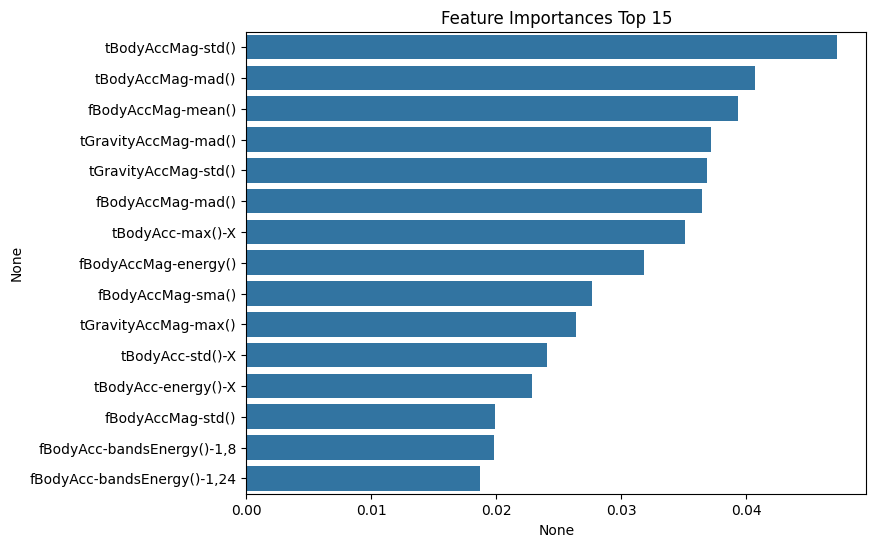

In [66]:
data['is_walking_down'] = np.where(data.Activity == 'WALKING_DOWNSTAIRS', 1, 0)
data['is_walking_down'].value_counts()

x = data.drop([target,'is_dynamic', 'is_standing','is_sitting','is_laying','is_walking','is_walking_up','is_walking_down'], axis=1)
y = data['is_walking_down']

x_trian, x_val, y_train, y_val = train_test_split(x, y, stratify=y, test_size=.2)
x_trian.shape, x_val.shape, y_train.shape, y_val.shape

model8 = RandomForestClassifier(random_state=1234)
model8.fit(x_trian, y_train)
pred8 = model8.predict(x_val)

print(classification_report(y_val, pred8))

ser = pd.Series(model8.feature_importances_, index=list(x_train))
top15 = ser.sort_values(ascending=False)[:15]
plt.figure(figsize=(8,6))
plt.title('Feature Importances Top 15')
sns.barplot(x=top15, y=top15.index)
plt.show()

importance8 = pd.DataFrame(model8.feature_importances_, columns=['importance8'])
# pd.merge(importance,feature,how='left',on)
importance8['feature_name'] = list(x_train)

feature8 = pd.merge(feature, importance8,on='feature_name')

In [ ]:
feature8.groupby('sensor')[['importance8']].sum().sort_values(by='importance8')

In [ ]:
feature8.groupby(['sensor','agg'])[['importance8']].sum().sort_values(by='importance8')

## 5.특성 중요도 저장하기

* **세부 요구사항**
    - 지금까지 변수 중요도를 다양한 관점에서 뽑고 분석을 해 보았습니다.
        - 관점1 : 6개 행동 구분
        - 관점2 : 동적, 정적 행동 구분
        - 관점3 : Standing 여부 구분
        - 관점4 : Sitting 여부 구분
        - 관점5 : Laying 여부 구분
        - 관점6 : Walking 여부 구분
        - 관점7 : Walking_upstairs 여부 구분
        - 관점8 : Walking_downstairs 여부 구분
    - 모든 관점의 변수 중요도를 하나로 합친 후 저장
        - merge를 이용하여 features와 합칩니다.
        - joblib 패키지의 dump를 이용하여 결과를 저장합니다.

### (1) 하나로 합치기
* 합치기 위해서는 중요도 결과에서 feature_importance 칼럼 이름을 수정해야 합니다.
* pd.merge를 이용해서 하나씩 합치는 작업을 반복 합니다.

In [ ]:
feature_all = feature.copy()
feature_all = pd.merge(feature_all, importance,on='feature_name')
feature_all = pd.merge(feature_all, importance2,on='feature_name')
feature_all = pd.merge(feature_all, importance3,on='feature_name')
feature_all = pd.merge(feature_all, importance4,on='feature_name')
feature_all = pd.merge(feature_all, importance5,on='feature_name')
feature_all = pd.merge(feature_all, importance6,on='feature_name')
feature_all = pd.merge(feature_all, importance7,on='feature_name')
feature_all = pd.merge(feature_all, importance8,on='feature_name')


In [ ]:
feature_all

,sensor,agg,axis,feature_name,importance1,importance2,importance3,importance4,importance5,importance6,importance7,importance8
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000140,0.000017,0.000148,0.000688,0.000223,0.000297,0.000136,0.000361
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000214,0.000000,0.000298,0.001365,0.000136,0.000148,0.000305,0.000248
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000256,0.000017,0.000279,0.000144,0.000200,0.000085,0.000628,0.000249
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.008993,0.000068,0.002643,0.001722,0.001813,0.005022,0.009174,0.027227
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000285,0.000000,0.004377,0.000396,0.000046,0.000144,0.000170,0.001657
...,...,...,...,...,...,...,...,...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000432,0.000000,0.000920,0.000802,0.000000,0.000104,0.000343,0.000363
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000716,0.000000,0.001638,0.001777,0.000089,0.000102,0.000166,0.000144
558,angle,X,gravityMean,"angle(X,gravityMean)",0.023124,0.000161,0.014396,0.031672,0.051241,0.003258,0.008940,0.002489
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.024705,0.000026,0.082246,0.043418,0.041874,0.002258,0.021650,0.003296


### (2) 저장하기
* joblib.dump를 이용하시오.
* 저장할 파일의 확장자는 보통 .pkl 입니다.

In [ ]:
import joblib

In [ ]:
joblib.dump(filename='feature_all.pkl', value=feature_all)

['feature_all.pkl']